# 过拟合解决方法
从上文已经知道，一般出现模型过拟合，我们可以通过以下手段去解决：
+ 增加训练样本数量 => 从案例3.1可以看出通过增加训练集数量可以解决过拟合
+ 降低模型复杂度 => 实际中一般是通过正则化来达到目的（可以简单就不要追求复杂）
+ 增加正则化 => 主要有L1正则化和L2正则化，本质就是在损失函数中给模型的参数加一个惩罚，使的学到的参数尽可能简单
+ 提前停止训练 => early stop，当训练样本下降到一定的误差，并且测试样本误差也下降到一定程度提前终止训练
+ dropout => 训练的时候，随机的去掉一些网络中的隐藏层的节点
本章，我们重点介绍实际生产环境中用的比较多的处理过拟合的方法，正则化和dropout。
一般实际环境中，训练样本是及其宝贵的，需要我们想尽办法去获取，当训练样本足够多，过拟合就越不容易发生，所以这些手段只有训练样本比较稀缺的时候才需要用到。

下面我们通过两个实际案例来说明正则化和dropout真的可以一定程度上解决过拟合的问题：

1. 高维线性回归实验：通过正则化来解决过拟合
2. fashion-mnist图像识别：通过dropout来解决过拟合问题

## 1. 正则化解决过拟合
### 1.1 定义模型结构
为了更好的使用 pytorch lightling， 我们可以学习 pytorch lightling 为我们封装好的模型库 pytorch-lightning-bolts       
安装方式：`pip install pytorch-lightning-bolts`       
源码地址：https://github.com/PyTorchLightning/pytorch-lightning-bolts

In [24]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import pytorch_lightning as pl
import numpy as np

class HighDimLRModel(pl.LightningModule):

    def __init__(self, l1_strength=None, l2_strength=None):
        super(HighDimLRModel, self).__init__()
        self.l1_strength = l1_strength
        self.l2_strength = l2_strength
        self.n_train = 20  # 训练样本数量
        self.n_test = 100  # 测试样本数量
        self.n_dim = 200  # 样本特征数量
        self.true_w = torch.ones(self.n_dim, 1) * 0.01  # 样本权重都是 0.01
        self.true_b = 0.05  # 样本偏置
        self.layer_1 = torch.nn.Linear(self.n_dim, 1)
        self.epoch_valid_loss = []
        self.epoch_train_loss = []

    def forward(self, x):
        return self.layer_1(x)

    def training_step(self, batch, batch_idx):
        # 必须提供：定于训练过程
        x, y = batch

        # flatten any input
        x = x.view(x.size(0), -1)

        y_hat = self(x)

        loss = F.mse_loss(y_hat, y)

        # L1 regularizer
        if self.l1_strength is not None:
            l1_reg = torch.tensor(0.)
            for param in self.parameters():
                l1_reg += torch.norm(param, 1)
            loss += self.l1_strength * l1_reg

        # L2 regularizer
        if self.l2_strength is not None:
            l2_reg = torch.tensor(0.)
            for param in self.parameters():
                l2_reg += torch.norm(param, 2)
            loss += self.l2_strength * l2_reg

        tensorboard_logs = {'train_mse_loss': loss}
        progress_bar_metrics = tensorboard_logs
        return {
            'loss': loss,
            'log': tensorboard_logs,
            'progress_bar': progress_bar_metrics
        }

    def training_epoch_end(self, outputs):
        # 结束一轮训练，自测一下
        x, y = iter(self.train_loss_data).next()
        y_hat = self.forward(x)
        train_loss = F.mse_loss(y_hat, y)
        self.epoch_train_loss.append(train_loss.item())
        tensorboard_logs = {'train_loss': train_loss}
        return {'loss': train_loss, 'log': tensorboard_logs, 'progress_bar': tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        # 可选提供：定义测试过程
        x, y = batch
        y_hat = self.forward(x)
        loss = F.mse_loss(y_hat, y)
        tensorboard_logs = {'valid_loss': loss}
        return {'val_loss': loss, 'log': tensorboard_logs, 'progress_bar': tensorboard_logs}

    def validation_epoch_end(self, outputs):
        # 可选提供：定义验证过程，验证集上效果，每轮都会验证
        avg_val_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        self.epoch_valid_loss.append(avg_val_loss.item())
        tensorboard_logs = {'valid_loss': avg_val_loss}
        return {'val_loss': avg_val_loss, 'log': tensorboard_logs, 'progress_bar': tensorboard_logs}

    def configure_optimizers(self):
        # 必须提供：定义优化器
        # can return multiple optimizers and learning_rate schedulers
        # (LBFGS it is automatically supported, no need for closure function)
        return torch.optim.SGD(self.parameters(), lr=0.003)

    def prepare_data(self):
        # 准备数据集合，可选提供：lightling 默认会执行一次，防止重复执行
        self.features = torch.randn((self.n_train + self.n_test, self.n_dim), dtype=torch.float)
        mid_true_y = torch.matmul(self.features, self.true_w) + self.true_b
        print('mid_true_y shape', mid_true_y.shape)
        self.true_y = mid_true_y + torch.tensor(np.random.normal(0, 0.01, size=mid_true_y.size()), dtype=torch.float)

    def train_dataloader(self):
        # 必须提供：提供训练数据集
        self.train_loss_data = DataLoader(TensorDataset(self.features[:20, :], self.true_y[:20]), batch_size=20, shuffle=False, num_workers=0)
        return DataLoader(TensorDataset(self.features[:20, :], self.true_y[:20]), batch_size=1, shuffle=True, num_workers=0)

    def val_dataloader(self):
        # 可选提供：提供测试数据集
        return DataLoader(TensorDataset(self.features[20:, :], self.true_y[20:]), batch_size=100, shuffle=False, num_workers=0)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 201   
mid_true_y shape torch.Size([120, 1])


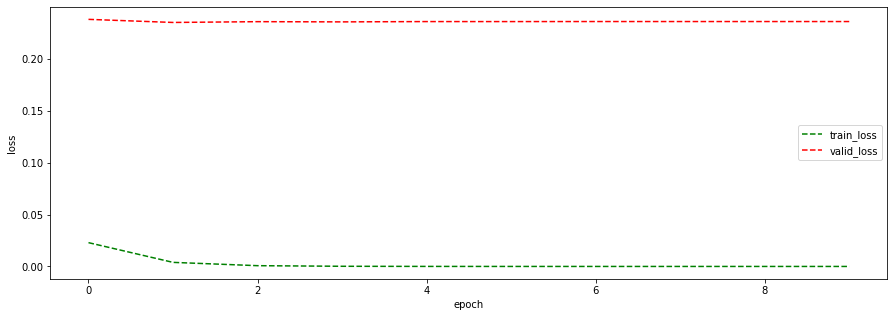

In [25]:
hdlr_model = HighDimLRModel()
trainer = pl.Trainer(logger=False, max_epochs=10, num_sanity_val_steps=0, progress_bar_refresh_rate=0)
trainer.fit(hdlr_model)

import matplotlib.pyplot as plt  
def plot_epoch_loss(train_loss_list, test_loss_list):
    x_vals = list(range(len(train_loss_list)))
    plt.figure(figsize=(15, 5))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(x_vals, train_loss_list, 'g--',label='train_loss')
    plt.plot(x_vals, test_loss_list, 'r--',label='valid_loss')
    plt.legend()
    plt.show()

plot_epoch_loss(hdlr_model.epoch_train_loss, hdlr_model.epoch_valid_loss)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 201   
mid_true_y shape torch.Size([120, 1])


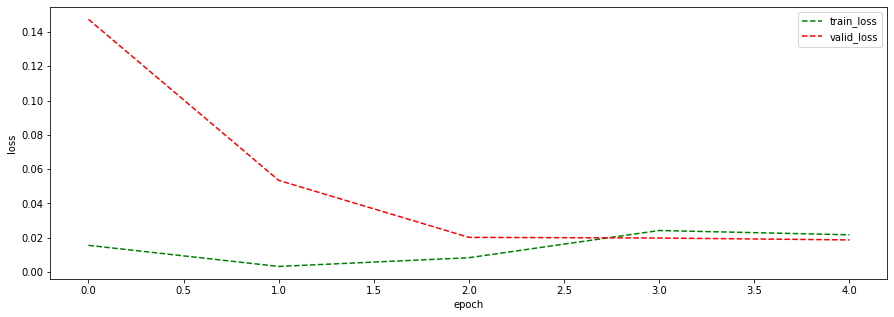

In [26]:
hdlr_model2 = HighDimLRModel(l2_strength=3)
trainer = pl.Trainer(logger=False, max_epochs=5, num_sanity_val_steps=0, progress_bar_refresh_rate=0, track_grad_norm=2)
trainer.fit(hdlr_model2)
plot_epoch_loss(hdlr_model2.epoch_train_loss, hdlr_model2.epoch_valid_loss)

可以看到加入正则化之后，训练集和测试集合的损失都可以将到比较合理的位置。